# ANN - Clasificación Titanic

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Si aparece error: pip install --upgrade tensorflow

## Lectura de Datos

In [65]:
df = pd.read_csv('titanic.csv')

In [67]:
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


## Limpieza de Datos

In [70]:
df[['Age']] = df[['Age']].fillna(value=df[['Age']].mean())
df[['Fare']] = df[['Fare']].fillna(value=df[['Fare']].mean())
df[['Embarked']] = df[['Embarked']].fillna(value=df['Embarked'].value_counts().idxmax())

In [72]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

## Planteamiento del modelo

In [75]:
X = df[['Age','Sex','Fare','Pclass', 'SibSp',	'Parch']]
y = df['Survived']

In [ ]:
# Tamaño de las matrices de entrada y salida
print("Shape de X:", X.shape)
print("Shape de y:", y.shape)

## Preprocesamiento

Haremos lo siguiente:


*   Binarización
*   Escalamiento
*   Hot encoding Y



### Variables Dummy (binarización)

In [80]:
X = pd.get_dummies(X, drop_first=True)

In [ ]:
# Revisar las variables después de crear dummies
X.head()

In [ ]:
# Columnas finales utilizadas como entrada al modelo
X.columns

### Escalamiento

In [85]:
from sklearn.preprocessing import StandardScaler

In [87]:
scaler = StandardScaler()
X_enc = scaler.fit_transform(X)

In [89]:
X_enc[:2]

array([[-0.5924806 , -0.50244517,  0.82737724,  0.43279337, -0.47367361,
         0.73769513],
       [ 0.63878901,  0.78684529, -1.56610693,  0.43279337, -0.47367361,
        -1.35557354]])

### One hot Y

In [92]:
y_enc = to_categorical(y, num_classes=2)

In [94]:
y_enc

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [ ]:
# Comprobamos dimensiones finales de X e y codificados
print("Shape de X_enc:", X_enc.shape)
print("Shape de y_enc:", y_enc.shape)

### Validacion Cruzada

In [98]:
from sklearn.model_selection import train_test_split

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X_enc, y_enc, test_size=0.33, random_state=42)

In [ ]:
# Dimensiones de los conjuntos de entrenamiento y prueba
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)

### Arquitectura de la red neuronal

La arquitectura es un arte. En este caso, utilizaremos capas densas (fully connected)

*  Probar con activation: relu, tanh, linear
*  Probar optimizadores: Adam, SGD, RMSProp, Adagrad
*  Probar combinaciones de capas

In [106]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

In [108]:
def build_model(layer_config=[32, 16], activation='relu', optimizer='adam'):
    model = Sequential()
    
    # 1. Definimos la entrada de forma explícita
    # Esto elimina el Warning y hace el modelo más robusto
    model.add(Input(shape=(X_train.shape[1],)))
    
    # 2. Ahora el bucle es más limpio: procesamos TODAS las unidades
    # ya no necesitamos separar layer_config[0] de layer_config[1:]
    for units in layer_config:
        model.add(Dense(units, activation=activation))
    
    # 3. Capa de salida
    model.add(Dense(2, activation='softmax'))  
    
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [110]:
# Probando diferentes combinaciones de funciones de activación y optimizadores
activations = ['relu', 'tanh', 'linear']
optimizers = ['adam', 'sgd', 'rmsprop', 'adagrad']
layer_configurations = [
    [64],       # Una sola capa de 64 neuronas
    [32, 16],   # Dos capas de 32 y 16 neuronas
    [64, 32, 16] # Tres capas de 64, 32 y 16 neuronas
]

# Entrenar y evaluar múltiples combinaciones

resultados = []

# Iterar sobre configuraciones de capas, funciones de activación y optimizadores
for layers in layer_configurations:
    for activation in activations:
        for optimizer in optimizers:
            print(f"Entrenando con capas={layers}, activation={activation}, optimizer={optimizer}")
            model = build_model(layer_config=layers, activation=activation, optimizer=optimizer)
            
            history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
            
            # Evaluación
            loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
            print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")
            
            # Almacenar resultados
            resultados.append({
                'layers': layers,
                'activation': activation,
                'optimizer': optimizer,
                'accuracy': accuracy
            })

Entrenando con capas=[64], activation=relu, optimizer=adam
Precisión en el conjunto de prueba: 0.8271
Entrenando con capas=[64], activation=relu, optimizer=sgd
Precisión en el conjunto de prueba: 0.8237
Entrenando con capas=[64], activation=relu, optimizer=rmsprop
Precisión en el conjunto de prueba: 0.8271
Entrenando con capas=[64], activation=relu, optimizer=adagrad
Precisión en el conjunto de prueba: 0.8068
Entrenando con capas=[64], activation=tanh, optimizer=adam
Precisión en el conjunto de prueba: 0.8136
Entrenando con capas=[64], activation=tanh, optimizer=sgd
Precisión en el conjunto de prueba: 0.8136
Entrenando con capas=[64], activation=tanh, optimizer=rmsprop
Precisión en el conjunto de prueba: 0.8203
Entrenando con capas=[64], activation=tanh, optimizer=adagrad
Precisión en el conjunto de prueba: 0.7932
Entrenando con capas=[64], activation=linear, optimizer=adam
Precisión en el conjunto de prueba: 0.8169
Entrenando con capas=[64], activation=linear, optimizer=sgd
Precisión 

### Visualización del modelo

In [ ]:
# Convertir resultados en un DataFrame
resultados_df = pd.DataFrame(resultados)

# Seleccionar la mejor configuración según la accuracy en test
mejor_modelo = resultados_df.loc[resultados_df['accuracy'].idxmax()]

best_model = build_model(
    layer_config=mejor_modelo['layers'],
    activation=mejor_modelo['activation'],
    optimizer=mejor_modelo['optimizer']
)

# Resumen de la arquitectura del mejor modelo
best_model.summary()

Model: "sequential_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_212 (Dense)               │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_213 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_214 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_215 (Dense)               │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,182 (24.15 KB)

 Trainable params: 3,090 (12.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,092 (12.08 KB)

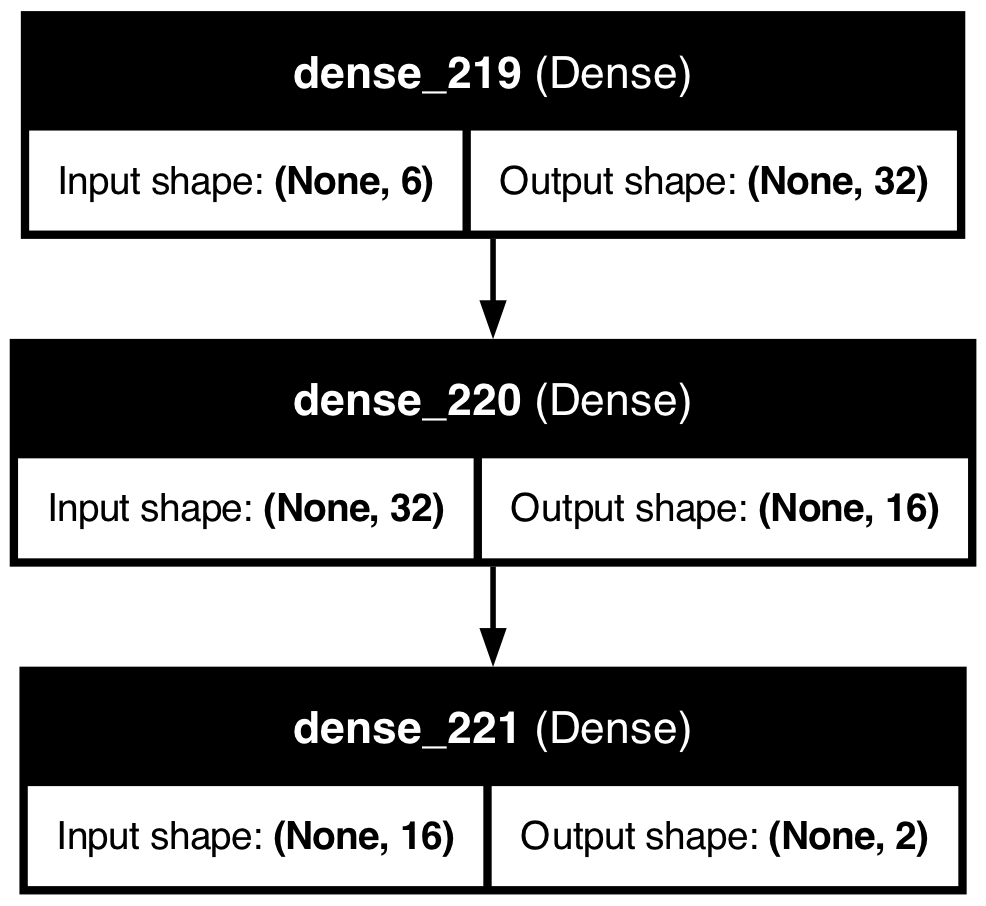

In [120]:
from tensorflow.keras.utils import plot_model

plot_model(best_model, to_file='best_ann_model.png', show_shapes=True, show_layer_names=True)

#plot_model(best_model, show_shapes=True, show_layer_activations=True)

### Entrenamiento

In [ ]:
# Entrenamos el mejor modelo encontrado
history = best_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

## Evaluación

In [122]:
from sklearn.metrics import accuracy_score

In [124]:


# Mostrar los detalles del mejor modelo
print("\nMejor modelo encontrado:")
print("Capas:", mejor_modelo['layers'])
print("Función de Activación:", mejor_modelo['activation'])
print("Optimizador:", mejor_modelo['optimizer'])
print("Precisión:", mejor_modelo['accuracy'])


Mejor modelo encontrado:
Capas: [32, 16]
Función de Activación: relu
Optimizador: rmsprop
Precisión: 0.8406779766082764


In [ ]:
# Predicciones del mejor modelo sobre el conjunto de prueba
y_test_labels = np.argmax(y_test, axis=1)
y_pred_proba = best_model.predict(X_test)
y_pred_labels = np.argmax(y_pred_proba, axis=1)

test_accuracy = accuracy_score(y_test_labels, y_pred_labels)
print("Accuracy en test (mejor modelo entrenado):", test_accuracy)

In [ ]:
# Métricas adicionales: matriz de confusión y reporte de clasificación
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test_labels, y_pred_labels)
print("Matriz de confusión:\n", cm)

print("\nReporte de clasificación:\n")
print(classification_report(y_test_labels, y_pred_labels))

## Evolución del entrenamiento

In [ ]:
# Claves disponibles en el historial de entrenamiento
history.history.keys()

In [ ]:
# train set

In [ ]:
# validation set


In [140]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Extraer datos del objeto history
    acc = history.history['accuracy']
    val_acc = history.history.get('val_accuracy') # Usar .get por si no hay validación
    loss = history.history['loss']
    val_loss = history.history.get('val_loss')
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Gráfico de Precisión (Accuracy)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Entrenamiento')
    if val_acc:
        plt.plot(epochs, val_acc, 'g', label='Validación')
    plt.title('Precisión (Accuracy)')
    plt.xlabel('Épocas')
    plt.legend()

    # Gráfico de Pérdida (Loss)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'c', label='Entrenamiento')
    if val_loss:
        plt.plot(epochs, val_loss, 'm', label='Validación')
    plt.title('Pérdida (Loss)')
    plt.xlabel('Épocas')
    plt.legend()

    plt.show()

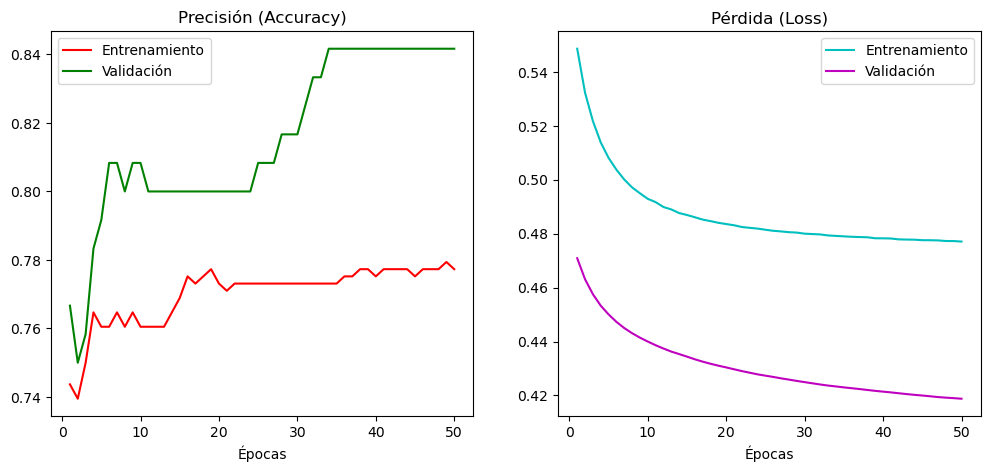

In [142]:
plot_history(history)